In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
from src.loaders import load_data, load_labels
from src.classify import MCM_Classifier
from src.plot import  plot_results
import os
from src.plot import plot_confusion_matrix, plot_label_prob_diff


In [2]:
# Customizable environment variables
n_categories = 10  # Number of categories to be classified
n_variables = 121  # Number of variables in the dataset
mcm_filename_format = "train-images-unlabeled-{}_comms.dat"
data_filename_format = "train-images-unlabeled-{}.dat"
data_path = "../INPUT/data/"
communities_path = "../INPUT/MCMs/"
output_path = "../OUTPUT/"

In [3]:
print("{:-^50}".format("  MCM-Classifier  ")) 

test_data = load_data("../INPUT/data/test-images-unlabeled-all-uniform.txt").astype(int)
test_labels = load_labels("../INPUT/data/test-labels-uniform.txt").astype(int)

# Step 1: Initialize classifier
classifier = MCM_Classifier(n_categories, n_variables, mcm_filename_format, data_filename_format, data_path, communities_path)

# Step 2: Train
classifier.fit(greedy=True, max_iter=1000000, max_no_improvement=100000)


# Step 3: Evaluate
predicted_classes, probs = classifier.predict(test_data, test_labels)

# Step 4: Save classification report and other stats
# report = classifier.get_classification_report(test_labels)
classifier.save_classification_report(test_labels,path=output_path)

if (classifier.stats == None):
    raise Exception("Classifier stats not found. Did you forget to call predict()?")


----------------  MCM-Classifier  ----------------


Generating bootstrap samples...
Done!
train-images-unlabeled-0_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-1_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-2_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-3_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-4_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-5_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-6_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-7_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-8_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-9_bootstrap filename
--------------------------------------------------
--  Running MinCompSpin_SimulatedAnnealing...  ---
--------------------------------------------------

✓ SAA for train-images-unl

In [4]:
classifier.get_P()[0][2]

array([0.01419355, 0.01493088, 0.00194553, 0.00194553, 0.00073733,
       0.0156682 , 0.00073733, 0.000553  , 0.00129032, 0.00194553,
       0.00194553, 0.00194553, 0.00194553, 0.00036866, 0.00194553,
       0.00194553, 0.00036866, 0.00036866, 0.00194553, 0.00194553,
       0.00194553, 0.00036866, 0.00194553, 0.00194553, 0.00194553,
       0.00194553, 0.00194553, 0.00194553, 0.00194553, 0.00194553,
       0.00194553, 0.00194553, 0.00534562, 0.00479263, 0.00194553,
       0.00194553, 0.00663594, 0.09898618, 0.000553  , 0.00110599,
       0.00294931, 0.00194553, 0.00147465, 0.00194553, 0.01069124,
       0.0121659 , 0.01013825, 0.00460829, 0.00194553, 0.00194553,
       0.00194553, 0.00194553, 0.00194553, 0.00194553, 0.00194553,
       0.00194553, 0.00194553, 0.00194553, 0.00194553, 0.00194553,
       0.00194553, 0.00194553, 0.00194553, 0.00194553, 0.00036866,
       0.000553  , 0.00194553, 0.00194553, 0.00036866, 0.00147465,
       0.00194553, 0.00194553, 0.00626728, 0.00092166, 0.00110

In [5]:

mcm_c3 = classifier.get_MCMs()[3]
mcm_c5 = classifier.get_MCMs()[5]

icc1_c3_P = classifier.get_P()[3][0] # icc 1 for class 3 probability distribution
icc1_c5_P = classifier.get_P()[5][0] # icc 1 for class 3 probability distribution
mcm_c5.shape,icc1_c3_P.shape

((21,), (4,))

In [6]:
# now for icc1_c3, see what P(C3|image_c5, icc1_c3)
data_c5 = load_data(os.path.join(data_path, data_filename_format.format(5)))
data_c3 = load_data(os.path.join(data_path, data_filename_format.format(3)))
data_c3.shape

(5423, 121)

In [7]:
data_c3[:,0]

array([0, 0, 0, ..., 0, 0, 1])

In [8]:

def generate_p_icc(data, P_MCM, n_variables,MCM,icc_idx):
    """Get probability distribution of single icc for some set of input images.
    E.g., what probabilities do we get for the first ICC in the MCM for the image of a 5 
    if we show it data of a 3. 
    ==> How good does this ICC differentiate between classes?
    P_MCM: is the probability distribution for the selected MCM
    """
    
    icc_Ps = np.zeros(len(data))
    for k, img in enumerate(data):
        idx = [i for i in range(n_variables) if MCM[icc_idx][i] == "1"]
        sm = int("".join([str(s) for s in img[idx]]), 2)
        icc_Ps[k] = P_MCM[icc_idx][sm] 
    return icc_Ps


In [9]:
def plot_histogram(icc_Ps, columns):
    plt.figure()
    for i in columns:
        plt.hist(icc_Ps[:, i])
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title('Histogram of icc_Ps')
    plt.legend([f'Digit {i}' for i in columns])
    plt.show()

In [10]:
# get probability distribution for single ICC for all categories

from re import A


all_MCM = classifier.get_MCMs()
P =  classifier.get_P()

model_nr = 3

all_P_icc = []


MCM = all_MCM[model_nr]
P_MCM = P[model_nr]
nr_icc = len(MCM)
nr_images = len(data_c3)
all_P_icc = np.zeros((nr_icc,nr_images,10))

for icc_idx in range(nr_icc):
    icc_Ps = np.zeros((nr_images,10)) # all samples same size
    # for different images, get the PDF of that one ICC fitted to one image
    for cat_idx in range(10):
        data = load_data(os.path.join(data_path, data_filename_format.format(cat_idx)))
        icc_Ps[:,cat_idx] = generate_p_icc(data,P_MCM,n_variables,MCM,icc_idx)
    all_P_icc[icc_idx,:,:] = icc_Ps


all_P_icc=np.array(all_P_icc)
    # columns_to_plot = range(10)
    # plot_histogram(icc_Ps, columns_to_plot)


In [11]:
res = all_P_icc[:,:,[2,5]].mean(axis=1)
res_diff = np.diff(res, axis=1)
res_diff = res_diff.reshape(-1, 1)


# plt.figure()
# plt.bar(list(range(len(res_diff))), res_diff.flatten(), bottom=0)
# plt.xlabel('Index')
# plt.ylabel('Difference in means')
# plt.title('MCM 3: Digits 5 vs.3')
# plt.show()




In [44]:
sorted_data[:4,:]

array([[ 0,  1],
       [ 0, 10],
       [ 1,  9],
       [ 1, 55]])

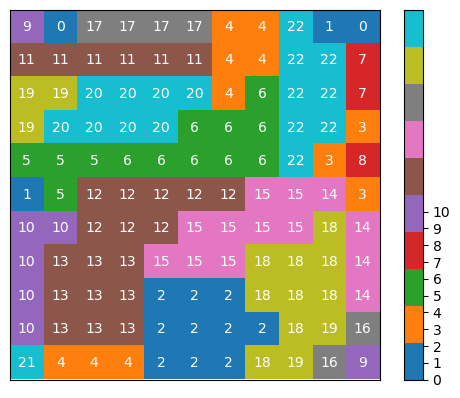

In [58]:
res_diff
MCM# Reshape the MCM array into a 2D numpy array
icc_arr = np.array([list(icc) for icc in MCM],dtype=int)
icc_arr
sorted_data = np.argwhere(icc_arr == 1)

grouped_data = np.split(sorted_data[:, 1], np.unique(sorted_data[:, 0], return_index=True)[1][1:])



out = np.empty(121)
for com_i, comm in enumerate(grouped_data):
    out[comm] = com_i
res = out.reshape((11,11))

import matplotlib.pyplot as plt

plt.imshow(res, cmap='tab10')
plt.colorbar(ticks=range(11))
plt.xticks([])
plt.yticks([])

# Add text in each cell
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        plt.text(j, i, int(res[i, j]), ha='center', va='center', color='white')

plt.show()


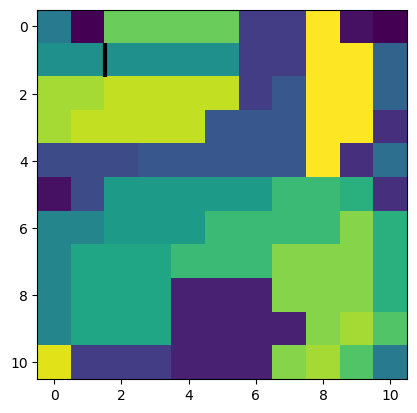

In [111]:
# def border(x, y, side, ax=None, **kwargs):
#     side_to_offset = {'t': (-.5, -.5, 1, 0), 'r': (.5, -.5, 0, 1), 'b': (-.5, .5, 1, 0), 'l': (-.5, -.5, 0, 1)}

#     if side not in side_to_offset:
#         raise ValueError("Invalid side value. Valid values are 't', 'r', 'b', 'l'.")
    
#     dx, dy, width, height = side_to_offset[side]
#     rect = plt.Rectangle((x+dx, y+dy), width, height, fill=False, **kwargs)
    
#     ax = ax or plt.gca()
#     ax.add_patch(rect)
#     return rect


# plt.imshow(res)

# border(1,1,"r",linewidth=3)

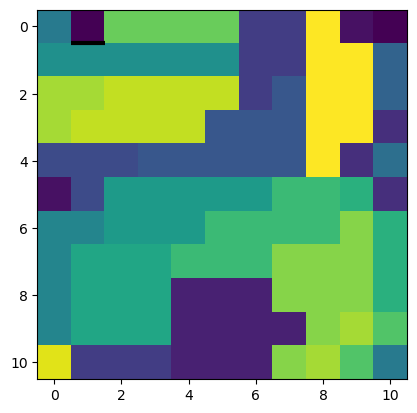

In [104]:
import matplotlib.colors as mcolors
white_cmap = mcolors.LinearSegmentedColormap.from_list("white_cmap", [(1, 1, 1), (1, 1, 1)])




def border(x, y, side, ax=None, **kwargs):
    side_to_offset = {'t': (-.5, -.5, 1, 0), 'r': (.5, -.5, 0, 1), 'b': (-.5, .5, 1, 0), 'l': (-.5, -.5, 0, 1)}

    if side not in side_to_offset:
        raise ValueError("Invalid side value. Valid values are 't', 'r', 'b', 'l'.")
    
    dx, dy, width, height = side_to_offset[side]
    rect = plt.Rectangle((x+dx, y+dy), width, height, fill=False, **kwargs)
    
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


# Define a colormap where all colors are white

# Use the colormap in imshow
plt.imshow(res)

border(1,1,"t",linewidth=3)


In [ ]:
import matplotlib.colors as mcolors

# Define a colormap where all colors are white
white_cmap = mcolors.LinearSegmentedColormap.from_list("white_cmap", [(1, 1, 1), (1, 1, 1)])

# Use the colormap in imshow
plt.imshow(res, cmap=white_cmap)

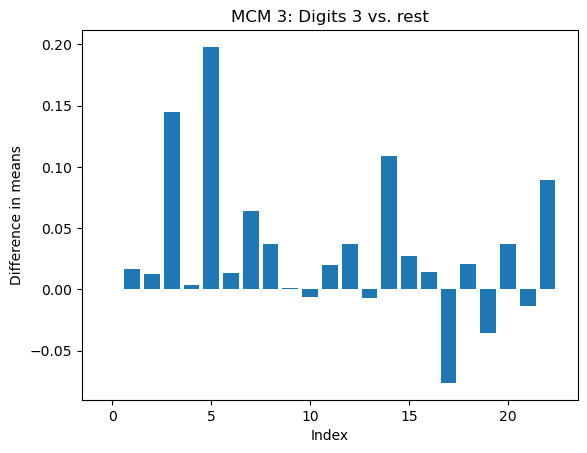

In [12]:
# difference in means class 3 vs. rest
res = all_P_icc.mean(axis=1)
res_diff = res[:,3] - res.mean(axis=1)

# res_diff = np.diff(res, axis=1)
# res_diff = res_diff.reshape(-1, 1)

plt.figure()
plt.bar(list(range(len(res_diff))), res_diff.flatten(), bottom=0)
plt.xlabel('Index')
plt.ylabel('Difference in means')
plt.title('MCM 3: Digits 3 vs. rest')
plt.show()

In [13]:
# now map these ICC to the pixels in the image using the MCM

MCM = all_MCM[model_nr]
# 

In [14]:
# need a co-occurance matrix of what it was called
# 121 by 121 of how destinctive that pixel is between 3 vs. 5

# 1 matrix = 1 image
# what icc these pixels are part of
